In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

<b>MNIST dataset has 70000 small images of digits handwritten by high school students and employees of the US Census Bureau. 

In [2]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

<b>Datasets loaded by Scikit-Learn have a similar dictionary structure including:</b>
* A DESCR key describing the datasets
* A data key containing an array with one row per instance and one column per feature
* A target key containing an array with the label


In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

<p><b> There are 784 features of each image. It is because each image is 28*28 pixels, and each feature simply represents one pixel's intensity from 0(white) to 255(black).</b></p>
Let's take a peak at one digit from the dataset. All we have to do is to grab an instance feature, reshape it to a 28*28 array, and display it using <b>Matplotlib's imshow()</b> function:


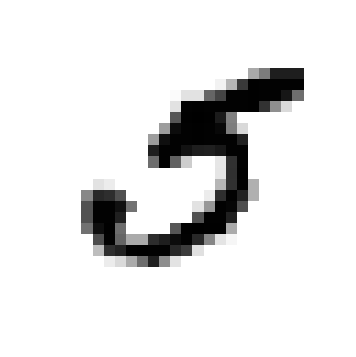

In [5]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_digit_index = 36000
some_digit = X[some_digit_index]
plot_digit(some_digit)

plt.show()

<b> This look like a 0 and label tell's the same. 

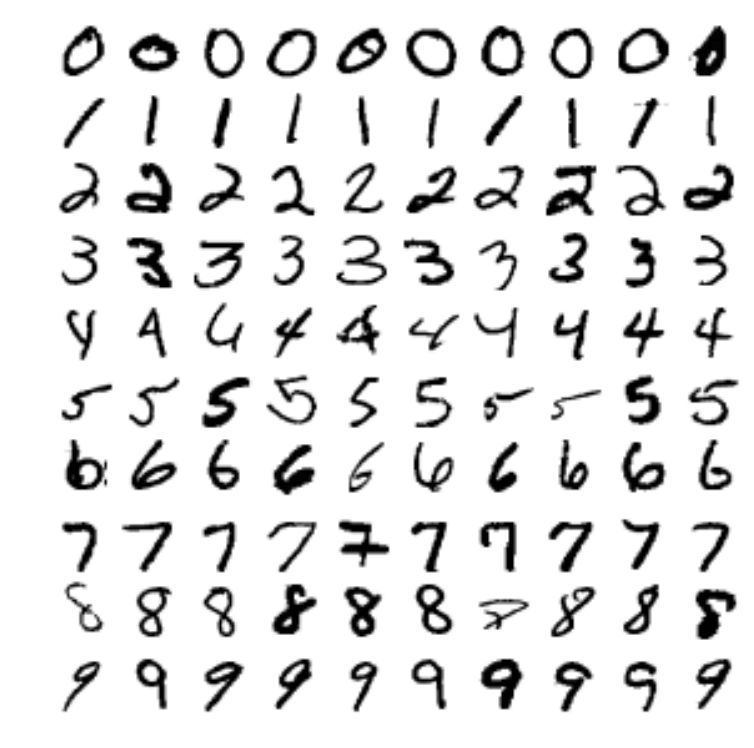

In [6]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)

plt.show()

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
#Let's suffle the training set
import numpy as np
shuffle_index = np.random.permutation(70000)

In [9]:
X = X[shuffle_index]
y = y[shuffle_index]

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<b> Training a binary classifier </b>

In [11]:
## let's create a classification task:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
## Now create a SGD(Stochastic Gradient Descent) classifier
## The SGD Classifier relies on randomness during training, hence the name Stochastic. 
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [13]:
sgd_clf.predict(X_test)

array([ 6.,  0.,  6., ...,  9.,  0.,  2.])

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9607 ,  0.96185,  0.9602 ])

<b> Performance Measure: Implementing Cross-Validation

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9607
0.96185
0.9602


In [16]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9064 ,  0.9113 ,  0.91215])

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_train_5, y_train_pred)
print(cfm)

[[53594  1003]
 [ 1342  4061]]


In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.80193522906793047

In [21]:
p_score = cfm[1][1]/(cfm[0,1] + cfm[1,1])
print(p_score)

0.801935229068


In [22]:
recall_score(y_train_5, y_train_pred)

0.75161947066444568

In [23]:
r_score = cfm[1,1]/sum(cfm[1])
print(r_score)

0.751619470664


In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.77596254896340888

In [25]:
f_score = 2/((1/p_score) + (1/r_score))
print(f_score)

0.775962548963


In [26]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([[ -69004.80613677, -522013.13901652, -264110.73033584,
        -202938.59435127, -392780.3440182 ,  103362.83243348,
        -708412.84233658, -244474.83969407, -771927.9749858 ,
        -758220.54994037]])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
np.sum(y_some_digit_pred)

[[False False False False False  True False False False False]]


1

In [28]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
np.sum(y_some_digit_pred)

[[False False False False False False False False False False]]


0

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [37]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [40]:
len(thresholds), len(precisions), len(recalls)

(59793, 59794, 59794)

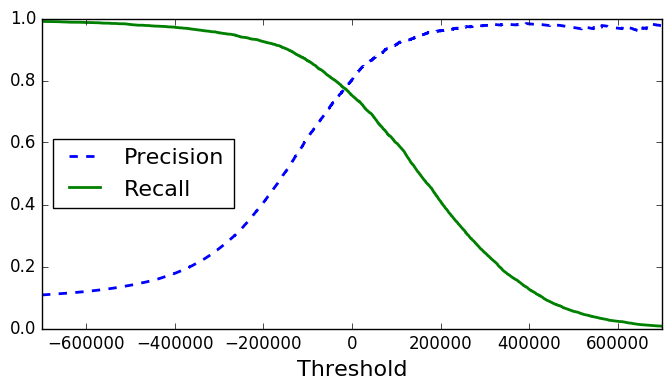

In [78]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="center left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])

plt.show()

In [75]:
y_train_pred_90 = (y_scores > 75572)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.900078472404
0.636868406441


In [32]:
(y_train_pred == (y_scores > 0)).all()

True

In [33]:
y_train_pred_90 = (y_scores > 70000)

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.89127654131491429

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.64482694799185636

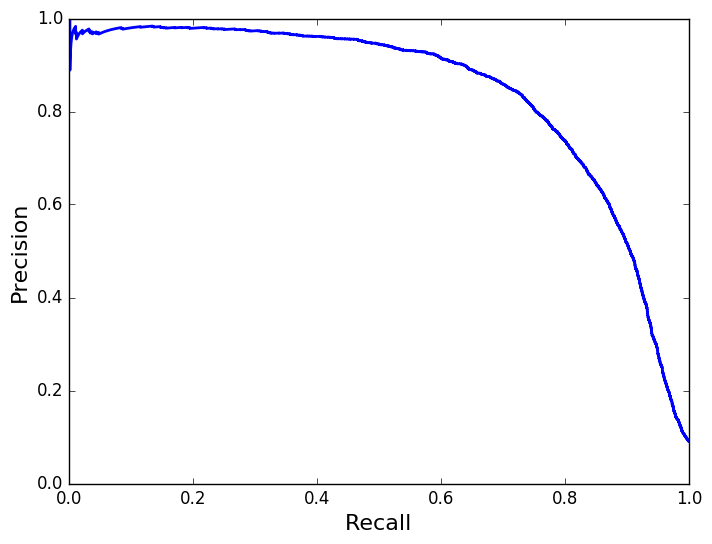

In [36]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

plt.show()

### The ROC Curve

The <i>receiver operating characteristicis</i> (ROC) curve is another common tool used with binary classifier. Instead of precision vs recall, we plot <b><i>true poistive rate</i></b> (recall) vs <b><i>false positive rate</i></b>. 
The <b>FPR</b> is the ration of negative instances that are correctly classified as positive <font color="red">(FN/(FN+TN))</font>. <br>
It is equal to one minus the <i>true negative rate</i>, which is the ration of negative instances that are correctly classified as negative<font color="red">(TN/(FN+TN))</font>. <br> The <b>TNR</b> is also called <i>specificity</i>. Hence the ROC curve plots <i>sensitivity</i> versus 1 - <i>specificity</i>. 

0.957264514222
0.957264514222


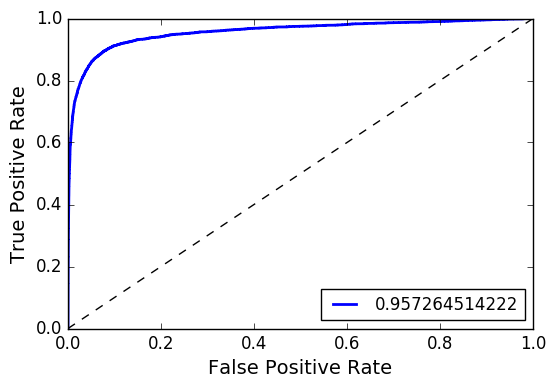

In [96]:
# To plot the ROC curve, calculate TPR and FPR for various threshold values, using the roc_curve() function

from sklearn.metrics import roc_curve, roc_auc_score, auc
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
area = roc_auc_score(y_train_5, y_scores)
print(area)
def plot_roc_curve(fpr, tpr, label = 'ROC curve (area = %0.2f)'):
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    plt.plot(fpr, tpr, linewidth = 2, label= roc_auc)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

plot_roc_curve(fpr, tpr)
plt.show()


<font color = "Blue"><b>Prefer PR(Precison-Recall) when positive class is rare or false positive is more importance than false negative, and the ROC curve otherwise. </b></font>

In [91]:
# Let's train a random forest classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

0.992915895232


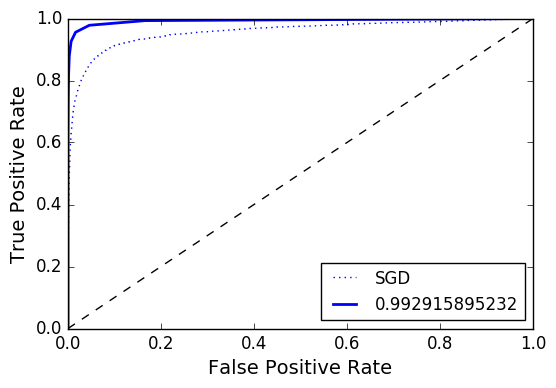

In [99]:
# But to plot a curve, we need scores not probabilities. A simple solution is to use the positive class's probability as the score

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
#plt.legend(loc = "bottom right")
plt.show()

In [101]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)

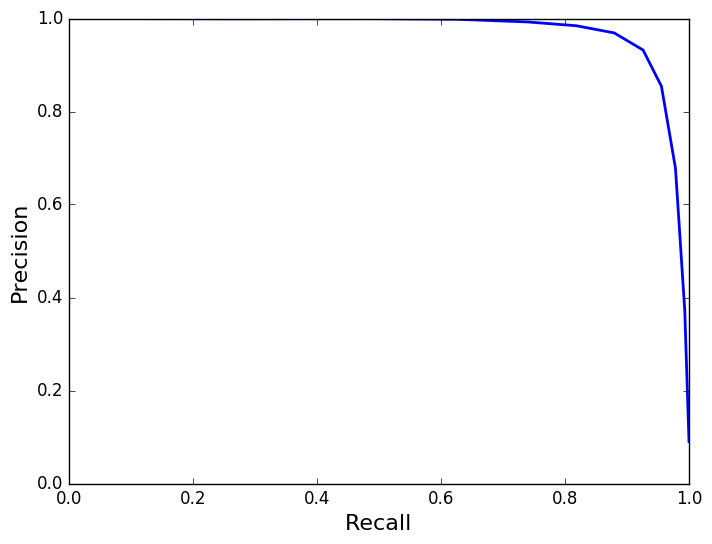

In [102]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

plt.show()

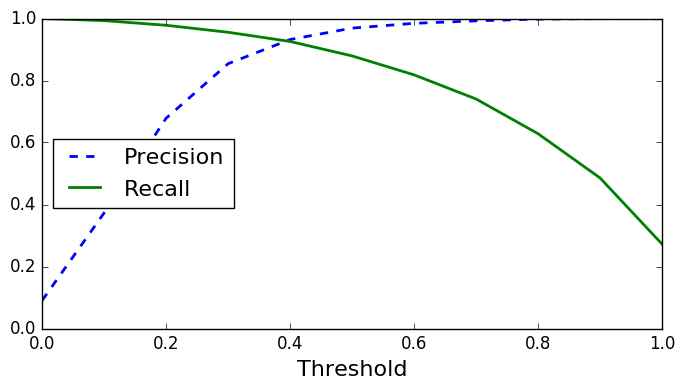

In [105]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0, 1])

plt.show()